# 5. CNN-LSTM

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Pseudo-Lab/Tutorial-Book-en/blob/master/book/chapters/en/time-series/Ch5-CNN-LSTM.ipynb)

In [1]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [2]:
!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils
!python Tutorial-Book-Utils/PL_data_loader.py --data COVIDTimeSeries
!unzip -q COVIDTimeSeries.zip

Cloning into 'Tutorial-Book-Utils'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 36 (delta 12), reused 17 (delta 5), pack-reused 0
Unpacking objects: 100% (36/36), done.
Downloading...
From: https://drive.google.com/uc?id=1B36Djko-f0LtVxSaBEVYosLTTsu0qtsh
To: /content/COVIDTimeSeries.zip
100% 3.18M/3.18M [00:00<00:00, 166MB/s]
COVIDTimeSeries.zip download complete!


In [3]:
# Load the cumulative COVID-19 cases for South Korea.
confirmed = pd.read_csv('time_series_covid19_confirmed_global.csv')
confirmed[confirmed['Country/Region']=='Korea, South']
korea = confirmed[confirmed['Country/Region']=='Korea, South'].iloc[:,4:].T
korea.index = pd.to_datetime(korea.index)
daily_cases = korea.diff().fillna(korea.iloc[0]).astype('int')


def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data.iloc[i:(i+seq_length)]
        y = data.iloc[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Data transformation for supervised learning data.
seq_length = 5
X, y = create_sequences(daily_cases, seq_length)

# Dividing the dataset into traning, validation, and test sets.
train_size = int(327 * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+33], y[train_size:train_size+33]
X_test, y_test = X[train_size+33:], y[train_size+33:]

MIN = X_train.min()
MAX = X_train.max()

def MinMaxScale(array, min, max):

    return (array - min) / (max - min)

# MinMax scaling
X_train = MinMaxScale(X_train, MIN, MAX)
y_train = MinMaxScale(y_train, MIN, MAX)
X_val = MinMaxScale(X_val, MIN, MAX)
y_val = MinMaxScale(y_val, MIN, MAX)
X_test = MinMaxScale(X_test, MIN, MAX)
y_test = MinMaxScale(y_test, MIN, MAX)

# Tensor transformation
def make_Tensor(array):
    return torch.from_numpy(array).float()

X_train = make_Tensor(X_train)
y_train = make_Tensor(y_train)
X_val = make_Tensor(X_val)
y_val = make_Tensor(y_val)
X_test = make_Tensor(X_test)
y_test = make_Tensor(y_test)

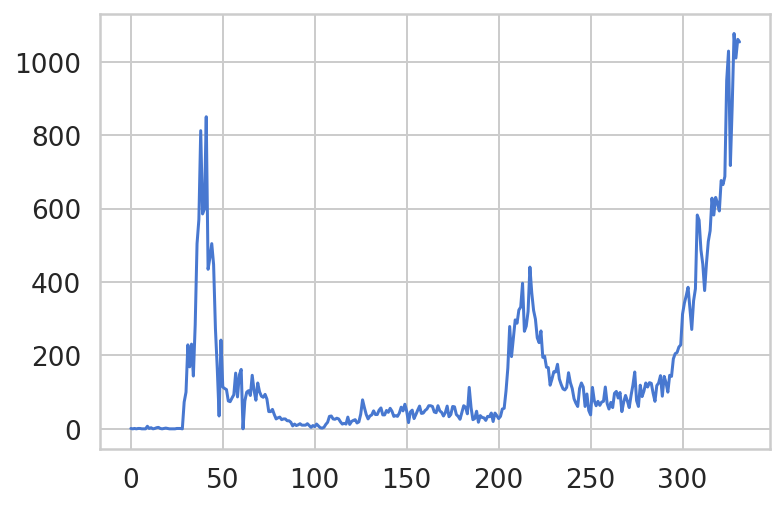

In [4]:
plt.plot(daily_cases.values)

In [5]:
c = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=2, stride=1)
input = torch.Tensor([[[1,2,3,4,5]]])
output = c(input)
output

tensor([[[1.5488, 2.6763, 3.8038, 4.9313]]], grad_fn=<ConvolutionBackward0>)

The 5 input examples generated 4 output values after passing through the 1D CNN with `kernel_size`=2. Next, we will find how the output values were generated. Let's view the values of weight and bias saved in `c`, first.

In [6]:
for param in c.parameters():
    print(param)

Parameter containing:
tensor([[[0.5406, 0.5869]]], requires_grad=True)
Parameter containing:
tensor([-0.1657], requires_grad=True)


The first values are the weights. The `kernel_size` is 2, so there are two values for weight. The next value is the bias value. In each 1D CNN layer, there is one bias value. We will save each value under `w1`, `w2`, and `b` respectively.

In [7]:
w_list = []
for param in c.parameters():
    w_list.append(param)

w = w_list[0]
b = w_list[1]

w1 = w[0][0][0]
w2 = w[0][0][1]

print(w1)
print(w2)
print(b)

tensor(0.5406, grad_fn=<SelectBackward0>)
tensor(0.5869, grad_fn=<SelectBackward0>)
Parameter containing:
tensor([-0.1657], requires_grad=True)


Through indexing, we saved the weight values under `w1`, `w2`, and `b`. Applying the math formula in Figures 5-2 and 5-3 used for the calculation of $y1$ and $y2$, we can calculate the `output` of the 1D CNN. The calculated output, when the 1D CNN filter passes 3 and 4, is shown in the following: 

In [8]:
w1 * 3 + w2 * 4 + b

tensor([3.8038], grad_fn=<AddBackward0>)

This result is the same as the third value of the `output`. The rest of the values are calculated in this way. 

In [9]:
output

tensor([[[1.5488, 2.6763, 3.8038, 4.9313]]], grad_fn=<ConvolutionBackward0>)

We will build the CNN-LSTM model now. The biggest difference from the LSTM model we built in chapter 4 is that we are adding the 1D CNN layer in this model. When viewing the code below, we can see that the 1D CNN layer was added to `CovidPredictor` through `nn.Conv1d`.

In [10]:
class CovidPredictor(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers):
        super(CovidPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.c1 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size = 2, stride = 1) # Add a 1D CNN layer
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers
        )
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len-1, self.n_hidden),
            torch.zeros(self.n_layers, self.seq_len-1, self.n_hidden)
        )
    def forward(self, sequences):
        sequences = self.c1(sequences.view(len(sequences), 1, -1))
        lstm_out, self.hidden = self.lstm(
            sequences.view(len(sequences), self.seq_len-1, -1),
            self.hidden
        )
        last_time_step = lstm_out.view(self.seq_len-1, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
        return y_pred

We will train the CNN-LSTM model using the `Adam` function we already built in chapter 4. We set `Adam` as the optimizer, with a learning rate of `0.001` and the loss function as `MAE (Mean Absolute Error)`.

In [11]:
def train_model(model, train_data, train_labels, val_data=None, val_labels=None, num_epochs=100, verbose = 10, patience = 10):
    loss_fn = torch.nn.L1Loss() #
    optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
    train_hist = []
    val_hist = []
    for t in range(num_epochs):

        epoch_loss = 0

        for idx, seq in enumerate(train_data): # hidden state needs to be reset after every sample

            model.reset_hidden_state()

            # train loss
            seq = torch.unsqueeze(seq, 0)
            y_pred = model(seq)
            loss = loss_fn(y_pred[0].float(), train_labels[idx]) # calculated loss after 1 step

            # update weights
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            epoch_loss += loss.item()

        train_hist.append(epoch_loss / len(train_data))

        if val_data is not None:

            with torch.no_grad():

                val_loss = 0

                for val_idx, val_seq in enumerate(val_data):

                    model.reset_hidden_state() # hidden state reset every sequence

                    val_seq = torch.unsqueeze(val_seq, 0)
                    y_val_pred = model(val_seq)
                    val_step_loss = loss_fn(y_val_pred[0].float(), val_labels[val_idx])

                    val_loss += val_step_loss
                
            val_hist.append(val_loss / len(val_data)) # append in val hist

            ## print loss for every `verbose` times
            if t % verbose == 0:
                print(f'Epoch {t} train loss: {epoch_loss / len(train_data)} val loss: {val_loss / len(val_data)}')

            ## check early stopping for every `patience` times
            if (t % patience == 0) & (t != 0):
                
                ## if loss increased, perform early stopping
                if val_hist[t - patience] < val_hist[t] :

                    print('\n Early Stopping')

                    break

        elif t % verbose == 0:
            print(f'Epoch {t} train loss: {epoch_loss / len(train_data)}')

            
    return model, train_hist, val_hist

In [12]:
model = CovidPredictor(
    n_features=1,
    n_hidden=4,
    seq_len=seq_length,
    n_layers=1
)

Let's briefly view the predicted model.

In [13]:
print(model)

CovidPredictor(
  (c1): Conv1d(1, 1, kernel_size=(2,), stride=(1,))
  (lstm): LSTM(1, 4)
  (linear): Linear(in_features=4, out_features=1, bias=True)
)


Let's train the model. 

In [14]:
model, train_hist, val_hist = train_model(
    model,
    X_train,
    y_train,
    X_val,
    y_val,
    num_epochs=100,
    verbose=10,
    patience=50
)

Epoch 0 train loss: 0.0835138894349936 val loss: 0.04996650665998459
Epoch 10 train loss: 0.03722365665913228 val loss: 0.03550177067518234
Epoch 20 train loss: 0.033955522599697856 val loss: 0.035930659621953964
Epoch 30 train loss: 0.03386474545006694 val loss: 0.033714406192302704
Epoch 40 train loss: 0.033425732912724104 val loss: 0.03444835543632507
Epoch 50 train loss: 0.03347257538734297 val loss: 0.0355195589363575
Epoch 60 train loss: 0.033300400439514224 val loss: 0.0345088467001915
Epoch 70 train loss: 0.03289526019520144 val loss: 0.03384614735841751
Epoch 80 train loss: 0.03293108241900202 val loss: 0.03531850129365921
Epoch 90 train loss: 0.03262793516179982 val loss: 0.034251559525728226


We will examine the training and test loss through visualization.

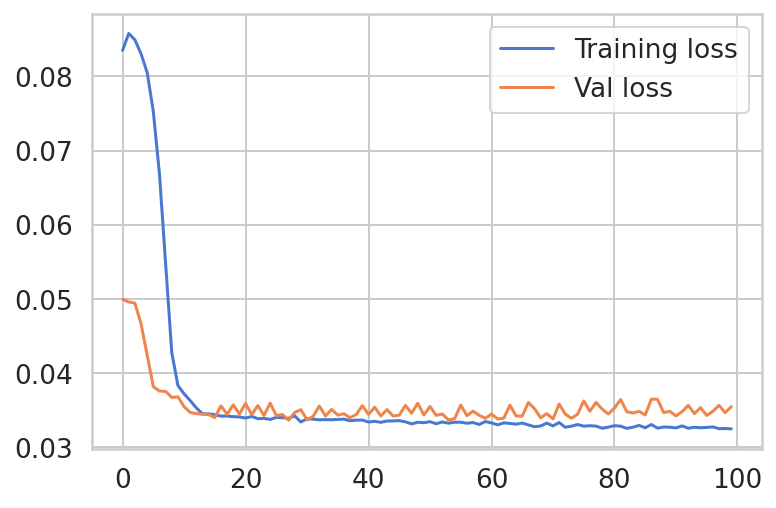

In [15]:
plt.plot(train_hist, label="Training loss")
plt.plot(val_hist, label="Val loss")
plt.legend()

We can see that both loss values are converging. 

In [16]:
pred_dataset = X_test

with torch.no_grad():
    preds = []
    for _ in range(len(pred_dataset)):
        model.reset_hidden_state()
        y_test_pred = model(torch.unsqueeze(pred_dataset[_], 0))
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)

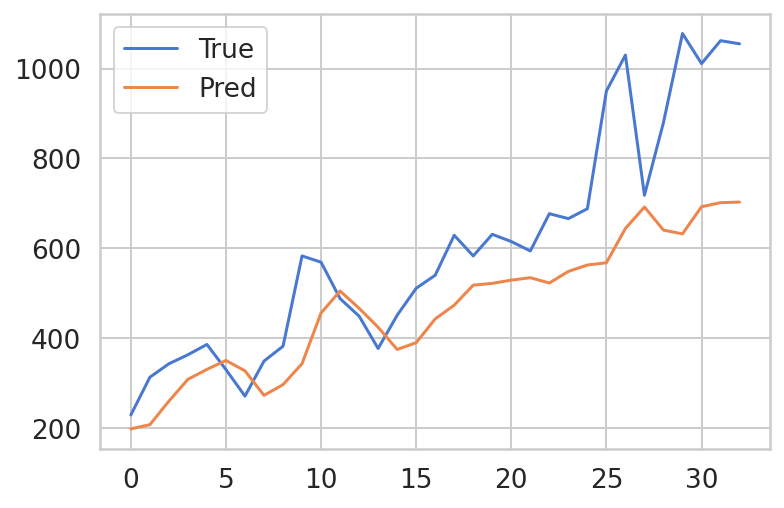

In [17]:
plt.plot(np.array(y_test)*MAX, label = 'True')
plt.plot(np.array(preds)*MAX, label = 'Pred')
plt.legend()

In [18]:
def MAE(true, pred):
    return np.mean(np.abs(true-pred))

In [19]:
MAE(np.array(y_test)*MAX, np.array(preds)*MAX)

246.46856934124992